# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Isoforms-Identified-in-all-Genotypes" data-toc-modified-id="Isoforms-Identified-in-all-Genotypes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Isoforms Identified in all Genotypes</a></div><div class="lev1 toc-item"><a href="#Number-of-Differentially-Expressed-Genes-(DEG)-in-each-genotype" data-toc-modified-id="Number-of-Differentially-Expressed-Genes-(DEG)-in-each-genotype-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Number of Differentially Expressed Genes (DEG) in each genotype</a></div><div class="lev1 toc-item"><a href="#Perturbation-Distributions" data-toc-modified-id="Perturbation-Distributions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Perturbation Distributions</a></div>

In [2]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import morgan as morgan

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [3]:
q = 0.1

In [4]:
tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv',
                           sep=',')

In [5]:
sorter = {'a': 6,
          'f': 7,
          'b': 2,
          'c': 4,
          'd':3,
          'e': 1,
          'g': 5
         }

genotype_mapping = {'a': 'egl-9;vhl-1',
                    'f': 'egl-9;hif-1',
                    'b': 'egl-9',
                    'c': 'hif-1',
                    'd': 'vhl-1',
                    'e': 'rhy-1',
                    'g': 'fog-2'
                    }

pretty_genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                           'f': r'\emph{egl-9;hif-1}',
                           'b': r'\emph{egl-9}',
                           'c': r'\emph{hif-1}',
                           'd': r'\emph{vhl-1}',
                           'e': r'\emph{rhy-1}',
                           'g': r'\emph{fog-2}'
                          }

# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']

# Specify which letters are double mutants and their genotype
double_mutants = {'a' : 'bd', 'f':'bc'}

In [6]:
# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [7]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [8]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genotype_mapping[key]
    frames += [df]
    df['sorter'] = sorter[key]

tidy = pd.concat(frames)
tidy['absb'] = tidy.b.abs()
tidy.sort_values('sorter', inplace=True)

# Isoforms Identified in all Genotypes

In [9]:
total_genes_id = tidy.target_id.unique().shape[0]
print("Total isoforms identified in all genotypes: {0}".format(total_genes_id))

Total isoforms identified in all genotypes: 13598


# Number of Differentially Expressed Genes (DEG) in each genotype

In [10]:
print('Genotype: DEG')
for x in tidy.genotype.unique():
    sel = (tidy.qval < q) & (tidy.genotype == x)
    s = tidy[sel].ens_gene.unique().shape[0]
    print(
"""{0}: {1}""".format(x, s))

Genotype: DEG
rhy-1: 1816
egl-9: 1487
vhl-1: 605
hif-1: 481
fog-2: 1896
egl-9;vhl-1: 1989
egl-9;hif-1: 364


# Perturbation Distributions

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

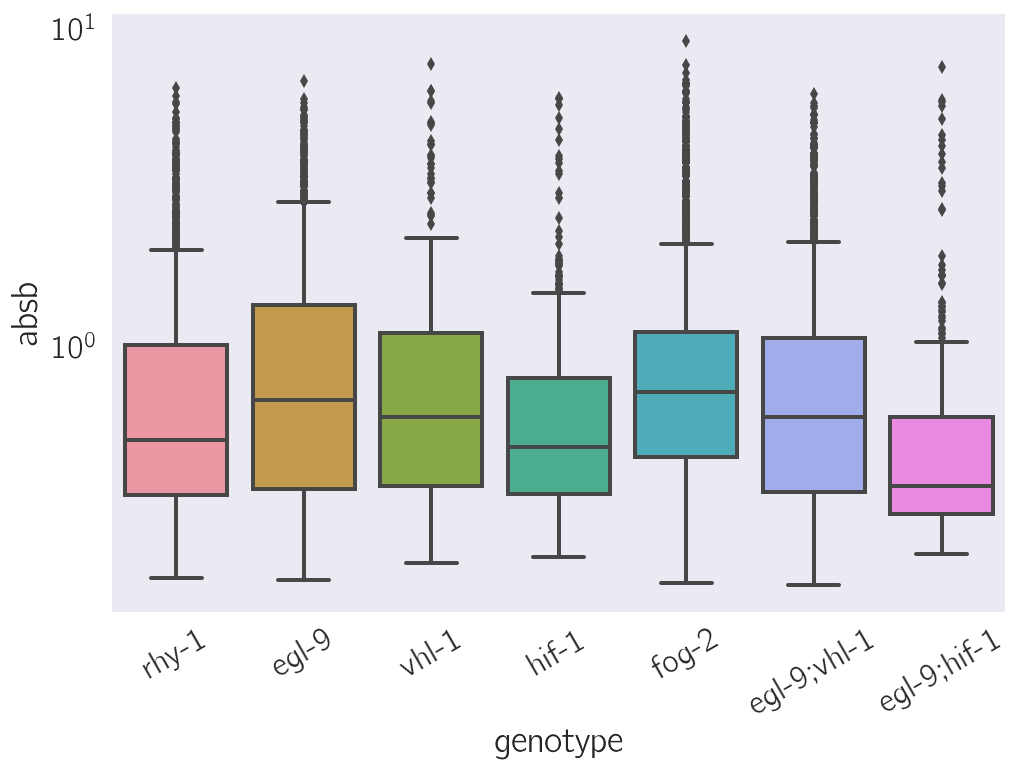

In [13]:
sns.boxplot(x='genotype', y='absb', data=tidy[tidy.qval < q])
plt.yscale('log')
plt.xticks(rotation=30)

In [14]:
sig = (tidy.qval < q)
for i, g1 in enumerate(tidy.genotype.unique()):
    genes1 = tidy[sig & (tidy.genotype == g1)]
    for j, g2 in enumerate(tidy.genotype.unique()[i+1:]):
        genes2 = tidy[sig & (tidy.genotype == g2)]
        
        # find the overlap between the two:
        n = genes2[genes2.ens_gene.isin(genes1.ens_gene)].shape[0]
        OR = ((tidy.genotype == g1) | (tidy.genotype == g2)) 
        ntot = tidy[sig & OR].shape[0]
        print("{0} and {1} share {2} genes".format(
              g1, g2, n)
             )
#         print("{0} and {1} share {2:.2g}% of their transcriptomes".format(
#               g1, g2, 100*n/ntot)
#              )

rhy-1 and egl-9 share 1133 genes
rhy-1 and vhl-1 share 440 genes
rhy-1 and hif-1 share 203 genes
rhy-1 and fog-2 share 618 genes
rhy-1 and egl-9;vhl-1 share 1177 genes
rhy-1 and egl-9;hif-1 share 233 genes
egl-9 and vhl-1 share 463 genes
egl-9 and hif-1 share 180 genes
egl-9 and fog-2 share 593 genes
egl-9 and egl-9;vhl-1 share 1249 genes
egl-9 and egl-9;hif-1 share 203 genes
vhl-1 and hif-1 share 113 genes
vhl-1 and fog-2 share 298 genes
vhl-1 and egl-9;vhl-1 share 569 genes
vhl-1 and egl-9;hif-1 share 115 genes
hif-1 and fog-2 share 204 genes
hif-1 and egl-9;vhl-1 share 245 genes
hif-1 and egl-9;hif-1 share 65 genes
fog-2 and egl-9;vhl-1 share 721 genes
fog-2 and egl-9;hif-1 share 123 genes
egl-9;vhl-1 and egl-9;hif-1 share 275 genes
